In [1]:
import os
if not os.path.exists('common.py'):
    print('trying to find project root directory by chaning to parent directory')
    os.chdir('..')
if os.path.exists('common.py'):
    print('all good')
else:
    print('could not find project root directory')

trying to find project root directory by chaning to parent directory
all good


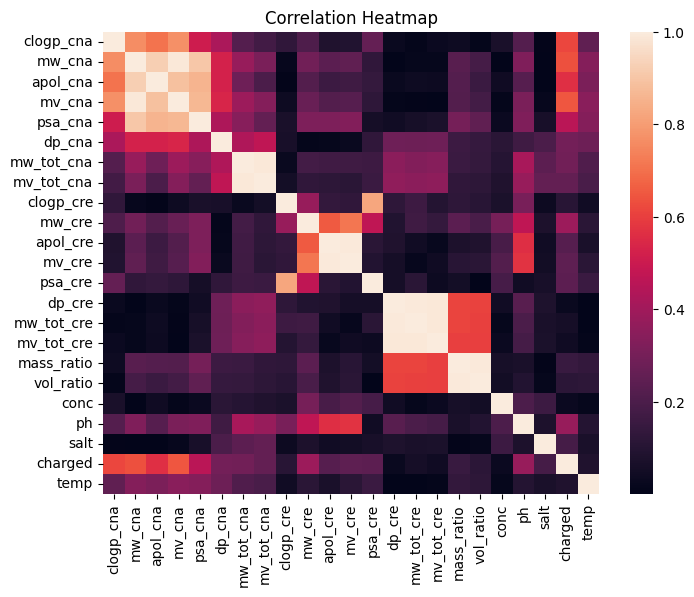

In [2]:
import data
from matplotlib import pyplot as plt
import seaborn as sns
from common import OUTPUTPATH

plt.figure(figsize=(8, 6))
# calculate the correlation matrix
corr = abs(data.abbrev_x1.corr())

# plot the heatmap
ax=sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns).set(title='Correlation Heatmap')

plt.savefig(os.path.join(OUTPUTPATH, 'correlation_heatmap.pdf'), bbox_inches='tight', pad_inches=0) # matrix sorting

In [3]:
# confusion matrix
import pandas as pd
predicted_order = [
        "(0,0,0)",
        "(1,0,0)",
        "(0,1,0)",
        "(0,0,1)",
        "(1,1,0)",
        "(1,0,1)",
        "(0,1,1)",
        "(1,1,1)",
        'Total'
    ]
def create_empty_df(predicted_order=predicted_order):
    df = pd.DataFrame(dict(zip(predicted_order, [[0 for _ in predicted_order] for _ in predicted_order]))) # specific columns order
    df.index = predicted_order # specific row order
    df = pd.concat([df], keys=['Predicted'])
    df = pd.concat([df.T], keys=['Actual'])
    return df
create_empty_df()



Predicted                                                  \
                 (0,0,0) (1,0,0) (0,1,0) (0,0,1) (1,1,0) (1,0,1) (0,1,1)   
Actual (0,0,0)         0       0       0       0       0       0       0   
       (1,0,0)         0       0       0       0       0       0       0   
       (0,1,0)         0       0       0       0       0       0       0   
       (0,0,1)         0       0       0       0       0       0       0   
       (1,1,0)         0       0       0       0       0       0       0   
       (1,0,1)         0       0       0       0       0       0       0   
       (0,1,1)         0       0       0       0       0       0       0   
       (1,1,1)         0       0       0       0       0       0       0   
       Total           0       0       0       0       0       0       0   

                              
               (1,1,1) Total  
Actual (0,0,0)       0     0  
       (1,0,0)       0     0  
       (0,1,0)       0     0  
       (0,0,1)       0     0  
       (1,1,0)       0     0  
       (1,0,1)       0     0  
       (0,1,1)       0     0  
       (1,1,1)       0     0  
       Total         0     0

In [4]:
import _pickle as cPickle
with open(r"./output/interpolation.pkl", "rb") as input_file:
    interpolation = cPickle.load(input_file)

with open(r"./output/extrapolation.pkl", "rb") as input_file:
    extrapolation = cPickle.load(input_file)

In [5]:
from modules.experiments import KFold
import numpy as np

def modified_array(data): 
    return [ "(" + ",".join([str(code) for code in each[:-1]]) + ")" for each in data]

def confusion_matrix(model_name, splitter, groups, estimator=interpolation):
    """
    model_name: ['LR', 'GAM','RuleFit', 'RF']
    """
    df = create_empty_df()
    x, y = data.x1, data.y.replace(-1.0, 0.0)
    i = -1
    for train_idx, test_idx in splitter.split(x, y, groups):
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        i +=1
        # LR
        est = estimator.fitted_[model_name][i]
        predicted = est.predict(x_test)
        predicted = modified_array(predicted)
        actual = modified_array(y_test.values)
        for i in range(len(predicted)):
            col, row = predicted_order.index(predicted[i]), predicted_order.index(actual[i])
            df.values[row][col] += 1
            df.values[row][-1] += 1
            df.values[-1][col] += 1
            df.values[-1][-1] += 1
    df = df/df.values[-1][-1]
    return df

def model_prediction(model_name, splitter, groups, estimator=interpolation):
    x, y = data.x1, data.y.replace(-1.0, 0.0)
    i = -1
    predicted_list, org_list = [], []
    for train_idx, test_idx in splitter.split(x, y, groups):
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        i +=1
        # LR
        est = estimator.fitted_[model_name][i]
        predicted = est.predict(x_test)
        predicted_list += list(predicted)
        org_list += list(y_test.values)
    return np.array(predicted_list), np.array(org_list)

In [6]:
# combine all the models
model_names = ['LR', 'GAM','RuleFit', 'RF']
seed=1000
df_interpolation = dict(zip(model_names,
              [confusion_matrix(each, 
                                KFold(30, shuffle=True, random_state=seed), 
                                groups=data.comp_ids.array,
                                estimator=interpolation) for each in model_names]))

interpolation_predicted_dic = dict(zip(model_names,
                            [model_prediction(each, 
                                KFold(30, shuffle=True, random_state=seed), 
                                groups=data.comp_ids.array,
                                estimator=interpolation) for each in model_names]))

In [7]:
from modules.experiments import GroupKFoldSpecial
df_extrapolation = dict(zip(model_names,
              [confusion_matrix(each, 
                                GroupKFoldSpecial(len(set(data.comp_ids)), size=22), 
                                groups=data.comp_ids.array,
                                estimator=extrapolation) for each in model_names]))

from modules.experiments import GroupKFoldSpecial
extrapolation_predicted_dic = dict(zip(model_names,
              [model_prediction(each, 
                                GroupKFoldSpecial(len(set(data.comp_ids)), size=22), 
                                groups=data.comp_ids.array,
                                estimator=extrapolation) for each in model_names]))

#### Interpolation model performance

* confusion matrix

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np


def diff(a_list, b_list):
    return round(1-sum(np.array(a_list)==np.array(b_list))/len(a_list), 1)

def color_cell(a_list, b_list):
    # 1/3 red  #FF0000
    # 2/3 red  #CD0000
    # 3/3 red  #8B0000	
    # white #FFFAF0
    dif = diff(a_list, b_list)
    if dif == 1.0:
        return '#8B0000'
    elif dif == 0.0:
        return 'None'
    elif dif == 0.7:
        return "#CD0000"
    elif dif ==0.3:
        return '#ED3E3E'

def whole_color_cell(total_a_list, signle_b_list):
    color_list = []
    for each in total_a_list:
        color_list.append(color_cell(each, signle_b_list))
    return color_list
    

def format_float(num):
    if num== 0:
        return '-'
    elif num >= 1:
        return str(num)
    else:
        return str(num)[1:]

size_based_order = np.array([[0, 0, 0],
                    [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [1, 0, 1], [0, 1, 1], [1, 1, 1]])

                    
prob_colors = cm.get_cmap('OrRd')
target_counts = data.polymers[data.targets].replace(-1, 0).sum(axis=0).astype(np.int64)


h_mt = 16/17 # main table height

symb = np.vectorize(lambda x: 'x' if x==1 else ' ')
raw_row_list = list(symb(size_based_order))
row_list = [['S', ' ', ' '], [' ', 'W', ' '], [' ', ' ', 'V']] + raw_row_list


def find_index(index, alist=raw_row_list):
    index_list = []
    for i in range(len(alist)):
        if alist[i][index] == 'x':
            index_list.append(i)
    return index_list
    
def plot_confusion_matrix(dataframe, model_name, total_dic, title=None, ax=None):

    _predicted, _org = total_dic[model_name]
    ax = plt.gca() if ax is None else ax
    ax.table(cellText=np.array(row_list), bbox=[0, 1-h_mt, 3/12, h_mt], cellLoc='center', edges='open')

    # first column
    row1_values = sum(_org[:, 0])
    row2_values = sum(_org[:, 1])
    row3_values = sum(_org[:, 2])

    ax.table(cellText=np.array([[row1_values, row2_values, row3_values]]), cellColours = [[cm.gray(0.9)]*3], bbox=[0, 0, 3/12, 1/17], cellLoc='center', edges='closed')
    lr = round(dataframe[model_name], 3)
    col_sum = lr.values[-1]
    row_sum = lr.values[:, -1]
    lr = lr.values[:-1, :-1]

    # first columns
    for i in range(len(raw_row_list)):
        column_symbol = [[str(each)]for each in raw_row_list[i]]#+ [[str(each)]for each in lr[:, i]] + [[str(column_total)]]
        column_symbol = [each[0] for each in column_symbol]
        ax.table(cellText=column_symbol, cellLoc='center', 
        bbox=[3/12 + 1/12*(i), 1-h_mt/11*3, 1/12, h_mt/11*3], edges='open')

    # values table
    for i in range(lr.shape[0]):
        col_values = [[format_float(each) for each in lr[i]]]
        # return col_values
        ax.table(cellText=col_values, cellLoc='center', 
        cellColours = [whole_color_cell(raw_row_list, raw_row_list[i])],
        bbox=[3/12, 1-h_mt/11*(i+4), 8/12, h_mt/11], edges='closed')
    
    # total row
    ax.table(cellText=[[format_float(each) for each in col_sum]], cellLoc='center', cellColours = [[cm.gray(0.9)]*9],  bbox=[3/12, 0, 9/12, 1/17], edges='closed')

    # total column
    col1_values = sum(_predicted[:, 0])
    col2_values = sum(_predicted[:, 1])
    col3_values = sum(_predicted[:, 2])
    ax.table(cellText=[[str(col1_values)], [str(col2_values)], [str(col3_values)]] + [[format_float(each)] for each in row_sum[:-1]], cellLoc='center', cellColours = [[cm.gray(0.9)]]*11,  bbox=[11/12, 1/17, 1/12, 16/17], edges='closed')

    ax.tick_params(axis='x', bottom=False, top=False, labelbottom=False, labeltop=False)
    ax.tick_params(axis='y', left=False, labelleft=False)
    ax.set_title(title)


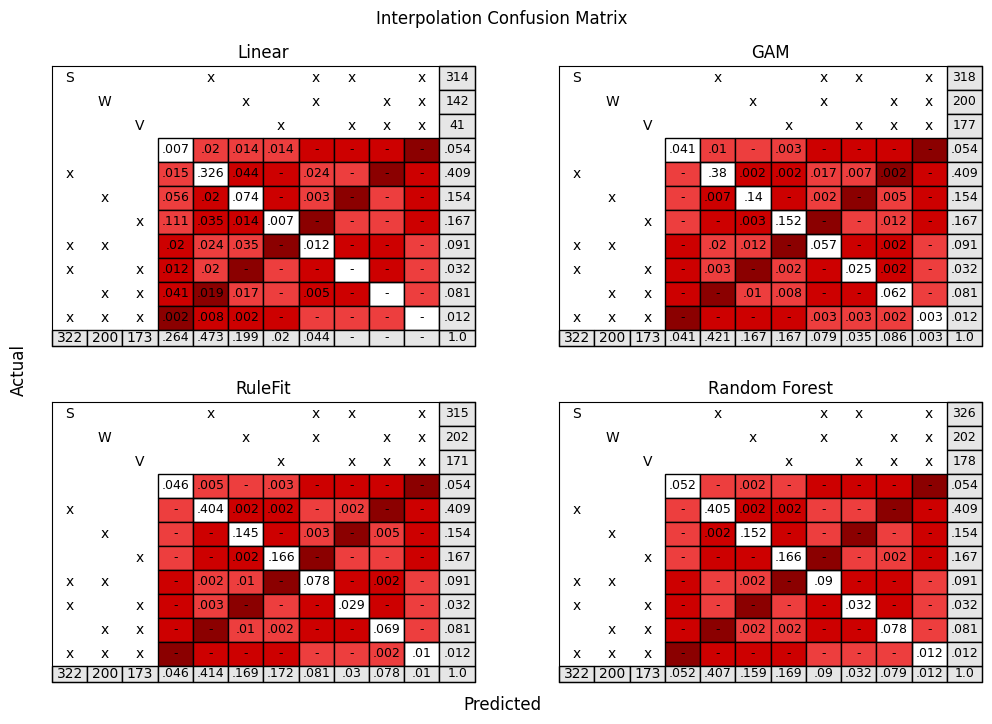

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_confusion_matrix(df_interpolation, 'LR', interpolation_predicted_dic, 'Linear', ax= axs[0][0])
plot_confusion_matrix(df_interpolation, 'GAM', interpolation_predicted_dic, 'GAM', ax= axs[0][1])
plot_confusion_matrix(df_interpolation, 'RuleFit', interpolation_predicted_dic, 'RuleFit', ax= axs[1][0])
plot_confusion_matrix(df_interpolation, 'RF', interpolation_predicted_dic, 'Random Forest', ax= axs[1][1])

fig.suptitle('Interpolation Confusion Matrix', y=0.95)
fig.supxlabel('Predicted', y=0.07)
fig.supylabel('Actual', x=0.09)
plt.savefig(os.path.join(OUTPUTPATH, 'interpolation_confusion_matrix.pdf'), bbox_inches='tight', pad_inches=0)

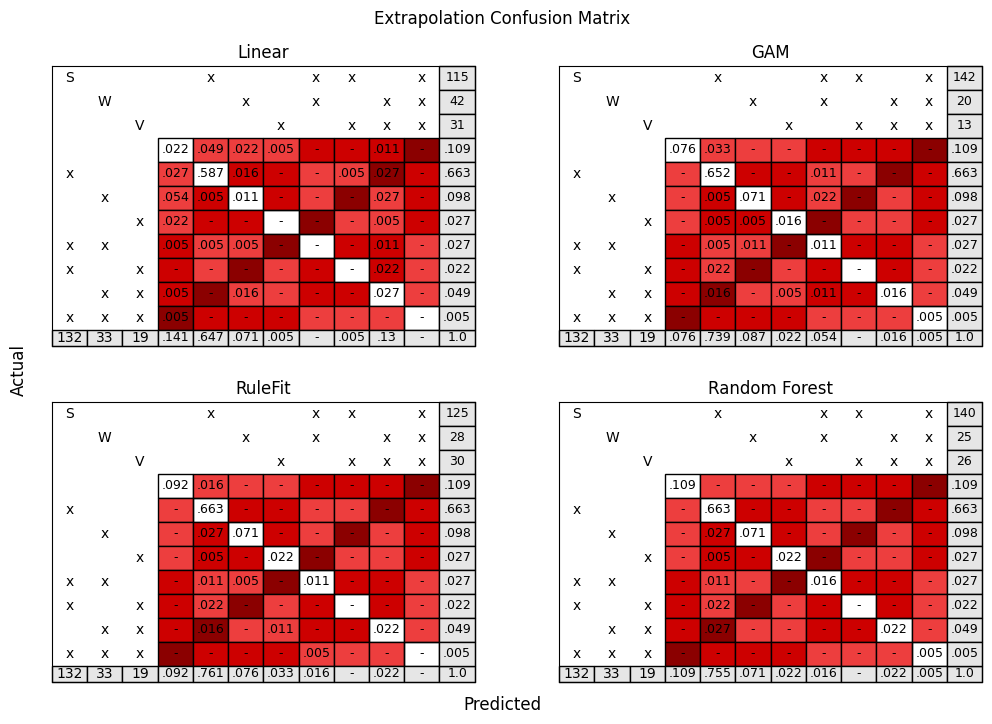

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_confusion_matrix(df_extrapolation, 'LR', extrapolation_predicted_dic, 'Linear', ax= axs[0][0])
plot_confusion_matrix(df_extrapolation, 'GAM', extrapolation_predicted_dic, 'GAM', ax= axs[0][1])
plot_confusion_matrix(df_extrapolation, 'RuleFit', extrapolation_predicted_dic, 'RuleFit', ax= axs[1][0])
plot_confusion_matrix(df_extrapolation, 'RF', extrapolation_predicted_dic, 'Random Forest', ax= axs[1][1])

fig.suptitle('Extrapolation Confusion Matrix', y=0.95)
fig.supxlabel('Predicted', y=0.07)
fig.supylabel('Actual', x=0.09)
plt.savefig(os.path.join(OUTPUTPATH, 'Extrapolaiton_confusion_matrix.pdf'), bbox_inches='tight', pad_inches=0)

In [11]:
# check confusion matrix actual total column
import numpy as np
np.unique([each[:-1] for each in data.y.values], return_counts=True, axis=0)

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([ 32,  99,  91,  48, 242,  19,  54,   7]))

/var/folders/c_/6873d_hj27z4bhy1l9x1tggnj8s0wd/T/ipykernel_84127/4026985843.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


Text(0.5, 1.03, 'Interpolation Confusion Matrix Heatmap')

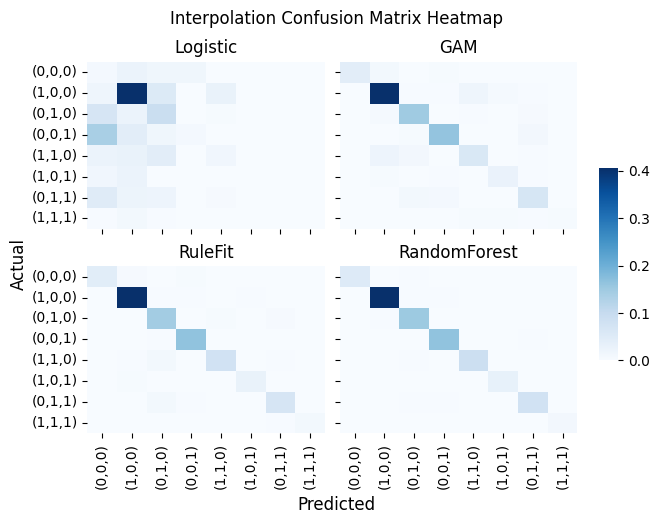

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def heatmap_subplot(df, title, ax=None, cbar=True, cbar_ax=None, cmap="Blues", predicted_order=predicted_order[:-1]):
    df = df.T['Actual'].drop(columns=['Total'])
    df = df.T['Predicted'].drop(columns=['Total'])

    sns.heatmap(df, 
            xticklabels=predicted_order,
            yticklabels=predicted_order, ax=ax, cbar=cbar, cbar_ax=cbar_ax, cmap=cmap).set(title=title)


fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

heatmap_subplot(df_interpolation['LR'], title='Logistic', ax=axn.flat[0], cbar=None)
heatmap_subplot(df_interpolation['GAM'], title='GAM', ax=axn.flat[1], cbar_ax=cbar_ax)
heatmap_subplot(df_interpolation['RuleFit'], title='RuleFit', ax=axn.flat[2], cbar_ax=cbar_ax)
heatmap_subplot(df_interpolation['RF'], title='RandomForest', ax=axn.flat[3], cbar_ax=cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])
fig.supxlabel('Predicted', y=-0.02)
fig.supylabel('Actual', x=-0.01)
fig.suptitle('Interpolation Confusion Matrix Heatmap', y=1.03)

#### Extrapolation model performance

* confusion matrix

/var/folders/c_/6873d_hj27z4bhy1l9x1tggnj8s0wd/T/ipykernel_84127/997033726.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


Text(0.5, 1.03, 'Extrapolation Confusion Matrix Heatmap')

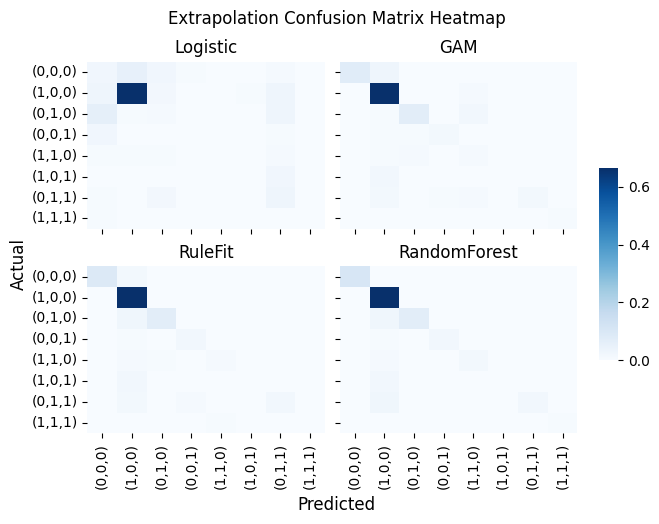

In [13]:
fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

heatmap_subplot(df_extrapolation['LR'], title='Logistic', ax=axn.flat[0], cbar=None)
heatmap_subplot(df_extrapolation['GAM'], title='GAM', ax=axn.flat[1], cbar_ax=cbar_ax)
heatmap_subplot(df_extrapolation['RuleFit'], title='RuleFit', ax=axn.flat[2], cbar_ax=cbar_ax)
heatmap_subplot(df_extrapolation['RF'], title='RandomForest', ax=axn.flat[3], cbar_ax=cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])
fig.supxlabel('Predicted', y=-0.02)
fig.supylabel('Actual', x=-0.01)
fig.suptitle('Extrapolation Confusion Matrix Heatmap', y=1.03)